<a href="https://colab.research.google.com/github/Akash-muneshwar/Deep-learning/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STARTING LINES OF CODE IS TO IMPORT THE DATASET FROM KAGGLE(You can ignore and directly go to code)

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240417%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240417T112106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbddd29c7d2ac8b55d497e18df801a4158c42a2bf3a18424d8a8cdb01bc4b21d96e1291724d22e89875d57ed5a8258f59e702d1ef29c4d68c25bc42e5d732ba27f943ce469671d7fc65672b8cb6bf5c74a9bae8094306afee9c32a90b35b6bc767716b5607c63fedb109752fe595c33404cafa5bf16bfd147862ab9519a947c19c6077349416e5c62d6a76fe496af3ccfc4fb87bd9db60c268fe246ede2502d0a870ed3e0d8913a58a6e6f663713da0f8eac1f9ccf5452b339a9cb66cc87e6dfaca067cd0fbb0f93246a89b3eef05665d436c5b5c7db335754ef70144f894bfd0adfeb8333cc455c0fe19ca9a4f28b289064490ded6041ab0b93fd0f97559187f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

import numpy as np

#def convert_to_rgb(image):
#   return np.repeat(image, 3, axis=-1)


def convert_to_rgb(image):
    # Ensure the image has shape (height, width, 1)
    if image.ndim == 2:  # if the image is grayscale, it would be 2D
        image = np.expand_dims(image, axis=-1)
    # Repeat the grayscale values across 3 channels
    return np.repeat(image, 3, axis=-1)


# Initializing ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Data augmentation: rotation
    width_shift_range=0.2,  # Data augmentation: horizontal shift
    height_shift_range=0.2,  # Data augmentation: vertical shift
    shear_range=0.2,  # Data augmentation: shearing
    zoom_range=0.2,  # Data augmentation: zooming
    horizontal_flip=True,  # Data augmentation: horizontal flip
    fill_mode='nearest',  # Fill strategy for new pixels
    #preprocessing_function=convert_to_rgb  # Apply RGB conversion
)

# Initializing ImageDataGenerator for test data without augmentation, only rescaling
test_datagen = ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=convert_to_rgb  # Apply RGB conversion
)

In [4]:
# Set the batch size
batch_size = 64

# Load and iterate training images with the generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=batch_size,
    color_mode='rgb',  # Images are in grayscale
    class_mode='categorical'  # For multi-class classification
)

# Load and iterate test images with the generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 model, exclude top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 expression categories

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', save_format='h5') # ERROR
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the model's validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the lowest validation loss
)

In [ ]:

#history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=[checkpoint], batch_size=32)

# Example model training, adjust the `steps_per_epoch` and `validation_steps` as needed
# Now, train the model with EarlyStopping (and ModelCheckpoint if you're using it) in the callbacks list
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Adjust based on your dataset
    epochs=2,  # You might increase epochs since EarlyStopping can halt training early
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,  # Adjust based on your dataset
    callbacks=[early_stopping, checkpoint]  # Add early_stopping to the list of callbacks
)

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/448 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.0586 - loss: 2.8252   

I0000 00:00:1712833305.257444      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712833305.294769      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


321/448 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.3147 - loss: 1.8749

W0000 00:00:1712833701.270810     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3276 - loss: 1.8151

W0000 00:00:1712833845.456937     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.3277 - loss: 1.8147 - val_accuracy: 0.4198 - val_loss: 1.5160
Epoch 2/2
  1/448 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.3906 - loss: 1.7195

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1712833888.734907      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3906 - loss: 1.7195 - val_accuracy: 0.3000 - val_loss: 1.4628


In [ ]:
model.save("face_mathching.h5")

In [ ]:
import shutil
from tensorflow.keras.models import load_model

# Path where the model file is stored
#/kaggle/input/emotionsim/best_model.keras
source_path = '/kaggle/input/emotionsim/best_model.keras'
# Destination path in a writable directory
destination_path = '/kaggle/working/best_model.keras'

# Copy the file
shutil.copy(src=source_path, dst=destination_path)

# Load the model from the new location
model = load_model(destination_path)


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np


# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Scale the image pixels to [0, 1]
    return img_array

# Function to predict the image
def predict_image(model, image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    return predictions

2024-04-17 10:25:46.163296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 10:25:46.163416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 10:25:46.291972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
image_path = '/kaggle/input/fer2013/train/happy/Training_10142161.jpg'

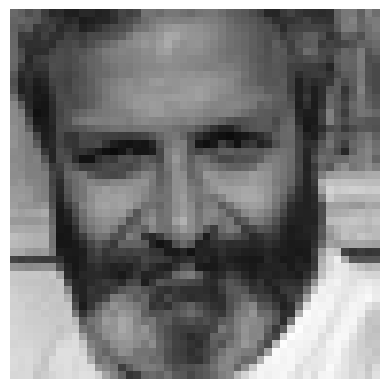

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb

def display_image(image_path):
    """Display an image."""
    img = plt.imread(image_path)
    if len(img.shape) == 2:  # If the image is grayscale
        img = gray2rgb(img)  # Convert grayscale to RGB
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

display_image(image_path)


In [ ]:
# Test the model with an image
#image_path = '/kaggle/input/fer2013/train/neutral/Training_10169962.jpg'
predictions = predict_image(model, image_path)
predicted_class = np.argmax(predictions, axis=1)
class_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
predicted_label = class_labels[predicted_class[0]]
print(f'Predicted expression: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted expression: Sad
